#### Power FLow Solver using Power Injection Method

In [24]:
# import necessary libaries and data files
import numpy as np
from data import datas
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')



#load data and manupulate datas if needed
bus_data, line_data, load_data, gen_data, wind_data = datas() #data loading

line_data = pd.DataFrame(line_data).sort_values(by=[0,1]).values #line data sorting and data type change

bus_data = pd.DataFrame(bus_data).sort_values(by = [0]).values #Bus data sorting and data type change

load_data = pd.DataFrame(load_data).sort_values(by = [0]).astype({0:'int'}).set_index(0) #Load data sorting and data type change

gen_data = pd.DataFrame(gen_data).sort_values(by = [0]).astype({0:'int'}).set_index(0) #Generation data sorting and data type change

wind_data = pd.DataFrame(wind_data).sort_values(by = [0]).astype({0:'int'}).set_index(0) #Wind Generation data sorting and data type change


base_mva = 100
R = line_data[:, 2]
X = line_data[:, 3]
B = 0.5j * line_data[:, 4]
taps = line_data[:,5]
Bsh = 1j* bus_data[:, 3]
Z = R + 1j * X
Y = 1 / Z
nline = len(line_data[:, 0])
nbus = int(np.amax(line_data[:, :2]))  # Total Number of buses



In [13]:
def tap_handle(x):
    '''Function to handle transformer tap ratio'''
    if np.real(x) == 0:
        return 1
    else:
        return complex(x)
    

# Y Bus Formation
def Y_bus():
    '''Function to create Y Bus matrix '''
    Ybus = np.zeros((nbus, nbus), dtype=complex)
    Y1 = np.zeros((73, 73), dtype=complex)
    np.fill_diagonal(Y1,Bsh)
    
    for k in range(nline):
        # Off Diagonal Elements
        Ybus[int(line_data[k, 0]) - 1, int(line_data[k, 1]) - 1] -= (Y[k])/np.conj(tap_handle(taps[k]))
        Ybus[int(line_data[k, 1]) - 1, int(line_data[k, 0]) - 1] -= (Y[k])/tap_handle(taps[k])

        # Diagonal Elements
        Ybus[int(line_data[k, 0]) - 1, int(line_data[k, 0]) - 1] += (Y[k] + B[k])/pow(abs(tap_handle(taps[k])),2)
        Ybus[int(line_data[k, 1]) - 1, int(line_data[k, 1]) - 1] += Y[k] + B[k]
    
    Y_bus_ = Ybus + Y1
    return Y_bus_

In [14]:
#Data from Bus_data
bus_no = bus_data[:, 0].astype(int)
bus_type = bus_data[:,1].astype(int)

#Data from Load_data
pl = np.zeros(nbus)
pf = np.zeros(nbus)
delta = np.zeros(nbus)
for k in load_data.index:
    pl[k-1] = load_data.loc[k, 2]/base_mva #base power
    pf[k-1] = load_data.loc[k, 1]
ql = pl * np.tan(np.arccos(pf))

#From Generation Data
pg_ = np.zeros(nbus)
qg = np.zeros(nbus)
vmag = np.ones(nbus)
qmin = np.zeros(nbus)
qmax = np.zeros(nbus)
for k in gen_data.index:
    pg_[k-1] = (gen_data.loc[k, 4]).sum()/base_mva
    vmag[k-1] = np.mean(gen_data.loc[k, 3])
    qmin[k-1] = gen_data.loc[k, 2].sum()
    qmax[k-1] = gen_data.loc[k, 1].sum()

# From Wind Data
pwg = np.zeros(nbus)
for k in wind_data.index:
    pwg[k-1] = (wind_data.loc[k, 4])/base_mva

pg = pg_ + pwg
b_data = pd.DataFrame()
b_data['Bus_No'] = bus_no
b_data['Bus_type'] = bus_type
b_data['Pg'] = pg
b_data['Qg'] = qg
b_data['Pl'] = pl
b_data['Ql'] = ql
b_data['Vmag'] = vmag
b_data['Delta'] = delta
b_data['Qmin'] = qmin/base_mva
b_data['Qmax'] = qmax/base_mva
b_data["P_sh"] = b_data["Pg"] - b_data["Pl"]
b_data["Q_sh"] = b_data["Qg"] - b_data["Ql"]
b_data = b_data.set_index('Bus_No')

In [15]:
def f_x(df_, y_bus):
    '''Function to calculate real and reactive power'''
    df = df_.copy(deep=True)
    P = np.zeros(nbus)
    Q = np.zeros(nbus)
    Y = np.absolute(y_bus)
    th = np.angle(y_bus, deg=False)
    for i in df.index:
        for j in df.index:
            P[i-1] += (df.loc[i, "Vmag"] * df.loc[j, "Vmag"] * Y[i-1, j-1] * 
                       np.cos(th[i-1, j-1] - df.loc[i, 'Delta'] + df.loc[j, 'Delta'] ))
            Q[i-1] -= (df.loc[i, "Vmag"] * df.loc[j, "Vmag"] * Y[i-1, j-1] * 
                       np.sin(th[i-1, j-1] - df.loc[i, 'Delta'] + df.loc[j, 'Delta'] ))

    return P, Q        


In [16]:
def delta_f_x(df_, y_bus):
    '''Function to calculate power mismatch'''
    P, Q = f_x(df_, y_bus)
    df_['P_calc'] = P
    df_['Q_calc'] = Q
    df_['D_P'] = df_['P_sh'] - df_['P_calc']
    df_['D_Q'] = df_['Q_sh'] - df_['Q_calc']

    return df_

In [17]:
def Jacobian(df, y_bus):
    '''Function to create Jacobian Matrix,
        Create reduced jacobian'''
    df_ = delta_f_x(df, y_bus)
    Y = np.absolute(y_bus)
    th = np.angle(y_bus, deg=False)

    #J1
    J1 = np.zeros((nbus, nbus))
    for i in df_.index:
        for j in df_.index:
            if i != j:
                J1[i-1, i-1] += (df_.loc[i, "Vmag"] * df_.loc[j, "Vmag"] * Y[i-1, j-1] *
                                 np.sin(th[i-1, j-1] - df_.loc[i, 'Delta'] + df_.loc[j, 'Delta'] )) #Diagonal element
                J1[i-1, j-1] = - (df_.loc[i, "Vmag"] * df_.loc[j, "Vmag"] * Y[i-1, j-1] * 
                                  np.sin(th[i-1, j-1] - df_.loc[i, 'Delta'] + df_.loc[j, 'Delta'] ))
    
    #J2
    J2 = np.zeros((nbus, nbus))
    for i in df_.index:
        for j in df_.index:
            if i != j:
                J2[i-1, i-1] += (df_.loc[j, "Vmag"] * Y[i-1, j-1]* 
                                 np.cos(th[i-1, j-1] - df_.loc[i, 'Delta'] + df_.loc[j, 'Delta'])) 
                
                J2[i-1, j-1] = df_.loc[i, "Vmag"] * Y[i-1, j-1] * np.cos(th[i-1, j-1] - df_.loc[i, 'Delta'] + df_.loc[j, 'Delta'] )

            else:
                J2[i-1, i-1] = 2 * df_.loc[i, "Vmag"] * Y[i-1, i-1] * np.cos(th[i-1, i-1])
    
    #J3
    J3 = np.zeros((nbus, nbus))
    for i in df_.index:
        for j in df_.index:
            if i != j:
                J3[i-1, i-1] += (df_.loc[i, "Vmag"] * df_.loc[j, "Vmag"] * Y[i-1, j-1] * 
                                 np.cos(th[i-1, j-1] - df_.loc[i, 'Delta'] + df_.loc[j, 'Delta']))
                J3[i-1, j-1] = -(df_.loc[i, "Vmag"] * df_.loc[j, "Vmag"] * Y[i-1, j-1] * 
                                 np.cos(th[i-1, j-1] - df_.loc[i, 'Delta'] + df_.loc[j, 'Delta']))
                
    #J4
    J4 = np.zeros((nbus, nbus))
    for i in df_.index:
        for j in df_.index:
            if i != j:
                J4[i-1, i-1] -= (df_.loc[j, "Vmag"] * Y[i-1, j-1]* 
                                 np.sin(th[i-1, j-1] - df_.loc[i, 'Delta'] + df_.loc[j, 'Delta'] )) 
                
                J4[i-1, j-1] = -(df_.loc[i, "Vmag"] * Y[i-1, j-1] * 
                                 np.sin(th[i-1, j-1] - df_.loc[i, 'Delta'] + df_.loc[j, 'Delta']))

            else:
                J4[i-1, i-1] = -2 * df_.loc[i, "Vmag"] * Y[i-1, i-1] * np.sin(th[i-1, i-1])
                
    #Reducing Jacobian
    J11 = J1[np.where(df_['Bus_type'] != 3)[0], :][:, np.where(df_['Bus_type'] != 3)[0]]
    J22 = J2[np.where(df_['Bus_type'] != 3)[0], :][:, np.where(df_['Bus_type'] == 1)[0]]
    J33 = J3[np.where(df_['Bus_type'] == 1)[0], :][:, np.where(df_['Bus_type'] != 3)[0]]
    J44 = J4[np.where(df_['Bus_type'] == 1)[0], :][:, np.where(df_['Bus_type'] == 1)[0]]

    #Reducing D_P and D_Q %% Determing indices
    d_p = df_.loc[(np.where(df_['Bus_type'] != 3)[0] + 1)]['D_P']
    d_q = df_.loc[(np.where(df_['Bus_type'] == 1)[0] + 1)]['D_Q']
    
    return d_p, d_q, np.block([[J11, J22], [J33, J44]])
    

In [18]:
def N_R(df, iter, tol):
    "Function to perform Newton Raphson for solving non linear equations"
    b_data_ = df.copy(deep=True)
    for i in range(iter):
        d_p, d_q, J = Jacobian(b_data_, Y_bus())
        DF = np.concatenate((d_p.values, d_q.values))
        DX = np.linalg.solve(J, DF) 
        #print( b_data_.loc[d_q.index, 'Vmag'])
        
        if max(np.abs(DX)) <= tol:
            return b_data_
        b_data_.loc[d_p.index, 'Delta'] = b_data_.loc[d_p.index, 'Delta'].values + DX[:d_p.shape[0]]
        b_data_.loc[d_q.index, 'Vmag'] = b_data_.loc[d_q.index, 'Vmag'].values + DX[d_p.shape[0]:]
    return "Value Error"
    

In [23]:
sol = N_R(b_data, 15, 0.001)
sol.head()

,Bus_type,Pg,Qg,Pl,Ql,Vmag,Delta,Qmin,Qmax,P_sh,Q_sh,P_calc,Q_calc,D_P,D_Q
Bus_No,,,,,,,,,,,,,,,
1,2,0.5282,0.0,0.5635,0.114718,1.035000,-0.445673,-0.5,0.8,-0.0353,-0.114718,-0.035300,0.408922,-4.953760e-09,-0.523640
2,1,0.0000,0.0,0.5041,0.103934,1.031571,-0.451058,-0.5,0.8,-0.5041,-0.103934,-0.504045,-0.103684,-5.498328e-05,-0.000250
3,1,0.0000,0.0,0.9342,0.192128,1.009587,-0.323436,0.0,0.0,-0.9342,-0.192128,-0.934188,-0.192041,-1.153927e-05,-0.000086
4,1,0.0000,0.0,0.3855,0.078077,1.012816,-0.431714,0.0,0.0,-0.3855,-0.078077,-0.385472,-0.077959,-2.836965e-05,-0.000119
5,1,0.0000,0.0,0.3707,0.073113,1.014260,-0.444342,0.0,0.0,-0.3707,-0.073113,-0.370668,-0.072988,-3.224850e-05,-0.000125


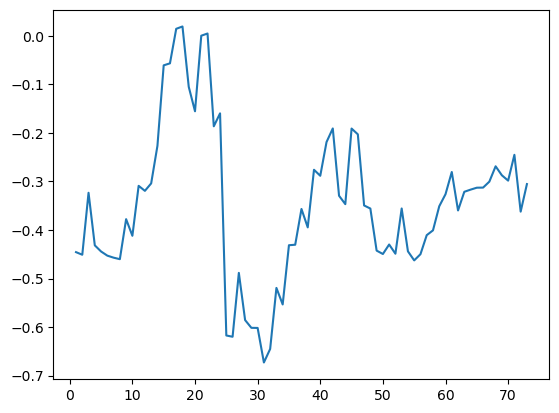

In [25]:
plt.plot(sol.index, sol['Delta'])

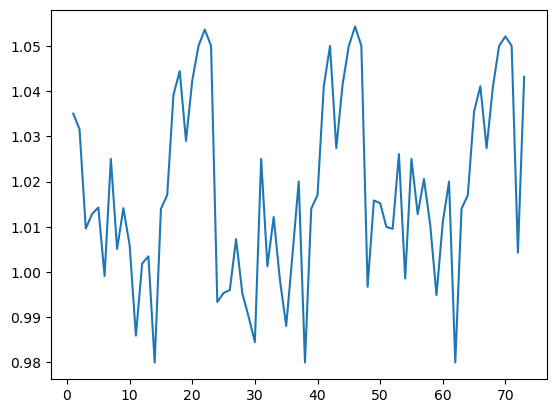

In [26]:
plt.plot(sol.index, sol['Vmag'])

In [20]:
def main(df, iter, tol):
    
    result = N_R(df, iter, tol)
    trig = 'yes'
    q_df = result.copy(deep = True)
    cond = True
    if isinstance(result, pd.DataFrame): #Checking Q Limit
        while cond == True:
            for k in q_df.index:
                if q_df.loc[k, 'Qmax'] != 0: #Checking for PV Bus
                    if q_df.loc[k, 'Q_calc'] > q_df.loc[k, 'Qmax']:
                        q_df.loc[k, 'Q_calc'] = q_df.loc[k, 'Qmax']
                        q_df.loc[k, 'Bus_type'] = 1 # PV becomes PQ
                        print("Qmax", k)
                        

                    elif q_df.loc[k, 'Q_calc'] < q_df.loc[k, 'Qmin']:
                        q_df.loc[k, 'Q_calc'] = q_df.loc[k, 'Qmin']
                        q_df.loc[k, 'Bus_type'] = 1 # PV becomes PQ
                        print("Qmin", k)
                               
                    else:
                        q_df.loc[k, 'Bus_type'] = 2 #PV restore
                        q_df.loc[k, 'Vmag'] = q_df.loc[k, 'Vmag']
                    
            cond =  ((q_df.loc[:, "Q_calc"] > q_df.loc[:, "Qmax"]) | 
                        (q_df.loc[:, "Q_calc"] < q_df.loc[:, "Qmin"])).any() 
            print(cond)  
            if cond == True:
                q_df = N_R(q_df, iter, tol)
                if isinstance(q_df, str):
                    return "The system is diverged for given number of iteration(While Checking Q Limit)"
                print("Evaluating q_df")
                q_df.head()

    else:
        print("The system is diverged for given number of iteration")
        
    return q_df
        
      

In [21]:
rslt = main(b_data, 15, 0.001)


Qmin 13
Qmin 15
Qmin 16
Qmin 38
Qmin 39
Qmin 62
Qmin 63
True


In [22]:
rslt

'The system is diverged for given number of iteration(While Checking Q Limit)'